In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path += ['..', '../src']

In [3]:
# Let's currently use free GPU, which I've found on the server
%env CUDA_VISIBLE_DEVICES=0
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_VISIBLE_DEVICES=0
env: CUDA_LAUNCH_BLOCKING=1


In [4]:
import os
from itertools import islice

from src.vocab import Vocab

DATA_PATH = '../data/generated'

train_src_path = os.path.join(DATA_PATH, 'news.ru.tok.bpe')
train_trg_path = os.path.join(DATA_PATH, 'dostoevsky.tok.bpe')

# Well, let's read only part of the News corpora, because there is too much of it
with open(train_src_path, 'r', encoding='utf-8') as train_src_file:
    num_lines_to_take = 500000
    train_src = list(islice(train_src_file, num_lines_to_take))

train_trg = open(train_trg_path, 'r', encoding='utf-8').read().splitlines()

# Removing empty sentences and tokenizing
train_src = [s.split() for s in train_src if len(s) != 0]
train_trg = [s.split() for s in train_trg if len(s) != 0]

Let's remove too short and too long sentences because... because they are not cool

In [5]:
min_len = 10
max_len = 60

print('Num lines before:', len(train_src), len(train_trg))

train_src = [s for s in train_src if min_len < len(s) < (max_len - 2)]
train_trg = [s for s in train_trg if min_len < len(s) < (max_len - 2)]

print('Num lines after :', len(train_src), len(train_trg))

Num lines before: 500000 100937
Num lines after : 425368 68513


In [6]:
vocab = Vocab.from_sequences([' '.join(s) for s in (train_src + train_trg)])

In [7]:
train_src_idx = [[vocab.token2id[t] for t in s] for s in train_src]
train_trg_idx = [[vocab.token2id[t] for t in s] for s in train_trg]

In [8]:
from sklearn.model_selection import train_test_split

train_src_idx, val_src_idx = train_test_split(train_src_idx, test_size=1000, random_state=42)
train_trg_idx, val_trg_idx = train_test_split(train_trg_idx, test_size=1000, random_state=42)

In [9]:
import os

from src.transformer.models import Transformer
from src.utils.data_utils import load_embeddings, init_emb_matrix
from src.models import TransformerClassifier

transformer_kwargs = {
    'd_model': 256,
    'd_word_vec': 256,
    'n_head': 4,
    'n_layers': 4
}

transformer = Transformer(len(vocab), len(vocab), max_len, **transformer_kwargs)
# TODO: try shared discriminator
discriminator_src = TransformerClassifier(len(vocab), 2, max_len, **transformer_kwargs)
discriminator_trg = TransformerClassifier(len(vocab), 2, max_len, **transformer_kwargs)

# Initializing transformer encoder and decoder with embeddings
# embeddings = load_embeddings('../trained_models/dostoevsky-news.tok.bpe.skipgram.vec')

# init_emb_matrix(transformer.encoder.src_word_emb.weight.data, embeddings, vocab.token2id)
# init_emb_matrix(transformer.decoder.tgt_word_emb.weight.data, embeddings, vocab.token2id)

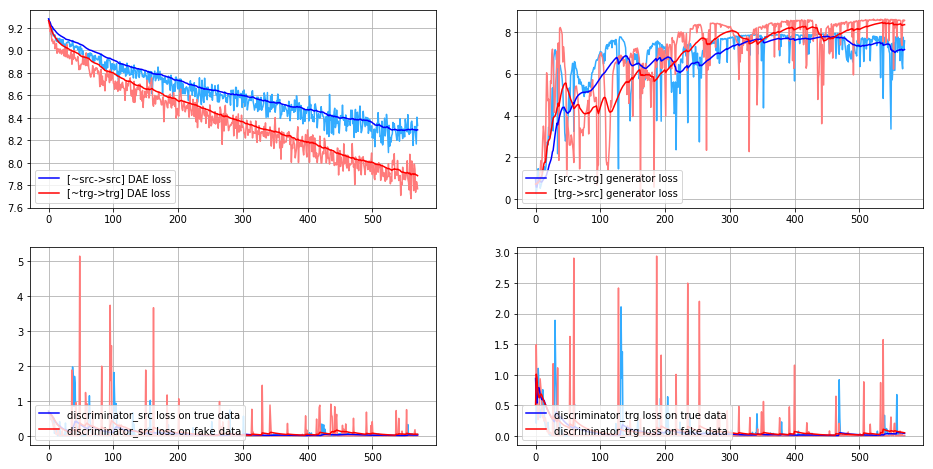

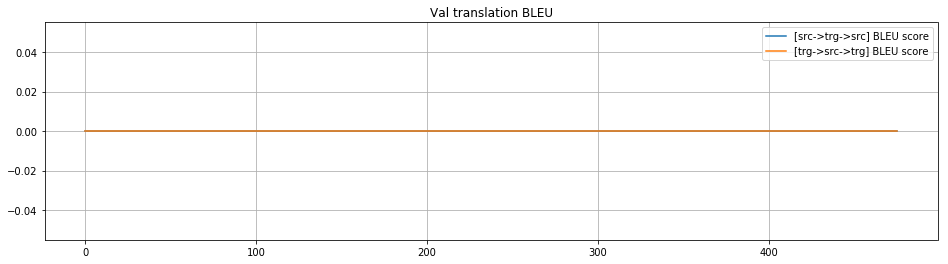

In [10]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam

%matplotlib inline

from src.trainers.trainer import Trainer
from src.utils.umt_batcher import UMTBatcher
from src.utils.batcher import Batcher
import src.transformer.constants as constants

use_cuda = torch.cuda.is_available()
log_file_path = '../logs/dae-style-transfer.log'

# Let's clean log file
if os.path.exists(log_file_path): os.remove(log_file_path)

def weighted_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)

reconstruction_criterion = weighted_criterion(len(vocab))
adv_criterion = nn.BCEWithLogitsLoss()

transformer_optimizer = Adam([
    {'params': transformer.get_trainable_params_without_embs(), 'lr': 1e-4},
    {'params': transformer.get_embs_parameters(), 'lr': 1e-5}
])
discriminator_src_optimizer = Adam(discriminator_src.get_trainable_parameters(), lr=1e-4)
discriminator_trg_optimizer = Adam(discriminator_trg.get_trainable_parameters(), lr=1e-4)

if use_cuda:
    reconstruction_criterion.cuda()
    adv_criterion.cuda()
    transformer.cuda()
    discriminator_src.cuda()
    discriminator_trg.cuda()

training_data = UMTBatcher(train_src_idx, train_trg_idx, vocab,
                           vocab, batch_size=8, shuffle=False)
val_data = Batcher(val_src_idx[:64], val_trg_idx[:64], vocab.token2id,
                   vocab.token2id, batch_size=8, shuffle=False)

tasks = ['dae', 'discriminate_translations']

models = {
    'translator': transformer,
    'discriminator_src': discriminator_src,
    'discriminator_trg': discriminator_trg
}

vocabs = {'vocab': vocab}

optimizers = {
    'translator_optimizer': transformer_optimizer,
    'discriminator_src_optimizer': discriminator_src_optimizer,
    'discriminator_trg_optimizer': discriminator_trg_optimizer
}

criterions = {
    'reconstruction_criterion': reconstruction_criterion,
    'adv_criterion': adv_criterion
}

config = {
    'max_num_epochs': 50,
    'generator_loss_coef_update_scheme': (0.1, 2, 30000),
    'temperature_update_scheme': (0.5, 0.1, 10000),
    'log_file': log_file_path,
    'is_vocab_shared': True,
    'is_translator_shared': True,
    'plot_every': 10,
    'val_bleu_every': 100,
    'max_len': max_len
}

trainer = Trainer(tasks, models, optimizers, criterions, vocabs, config)
trainer.run_training(training_data, val_data)